# Dispersion relationships in various systems of equations

A Jupyter notebook to visualize dispersion relationships for the following systems of equations.

* fully-compressible
* unified
* pseudo-incompressible
* analastic
* quasi-hydrostatic (primitive)

## References

[Arakawa, A., C. S. Konor, 2009](https://doi.org/10.1175/2008MWR2520.1): Unification of the anelastic and quasi-hydrostatic systems of equations. _Mon. Wea. Rev._, __137__, 710&ndash;726.

In [1]:
## Define constants and parameters

# %%
import math
import numpy as np
import matplotlib.pyplot as plt
import sys

# constants
gamma = 7 / 5
kappa = 1 - 1 / gamma
g = 9.8
a = 6.371e6
day_in_sec = 86400
om = math.tau / day_in_sec

# dictionary for systems with switches
# d, e, u1, u2
# d: delta
# e: epsilon
# u1: underlined
# u2: double underlined
systems = {
    "Fully-Compressible":  (1, 1, 1, 1),
    "Unified":             (1, 0, 1, 1),
    "Pseudo-Compressible": (1, 0, 0, 1),
    "Anelastic":           (1, 0, 0, 0),
    "Quasi-Hydrostatic":   (0, 1, 1, 1),
}

# parameters
H = 10.0e3           # scale height m
D = 100.0e3          # top of the atmosphere m
cs2 = gamma * g * H  # speed of sound squared
N2 = g * kappa / H   # Brunt-Väisälä frequency squared
lat = 40
f = 2 * om * np.sin(np.deg2rad(lat))
f2 = f ** 2
beta = 2 * om * np.cos(np.deg2rad(lat)) / a

nx = 61
nmode = 7

l = 10 ** np.linspace(2, 8, nx)
k = math.tau / l
l *= 1.0e-3
n = np.array([1, 5, 10, 20, 40, 80, 160])
m = np.pi * n / D
omega = np.empty((nmode, nx))


## Dispersion relationships

The linearized equations for the isosthermal atmosphere are
\begin{align}
\frac{\partial u}{\partial t} &= \;\;\;fv-\frac{\partial}{\partial x}\left(\frac{p}{\bar{\rho}}\right) \\
\frac{\partial v}{\partial t} &= -fu-\frac{\partial}{\partial y}\left(\frac{p}{\bar{\rho}}\right) \\
\delta\frac{\partial w}{\partial t} &= -\left(\frac{\partial}{\partial z}-\underline{\underline{\frac{\kappa}{H}}}\right)\frac{p}{\bar{\rho}}+g\frac{\theta}{\bar{\theta}} \\
\frac{\partial}{\partial t}\left(\frac{\theta}{\bar{\theta}}\right) &= -\frac{\kappa}{H}w \\
\frac{1}{c_\mathrm{s}^2}\frac{\partial}{\partial t}\left(\underline{\frac{p}{\bar{\rho}}}\right) &= -\frac{1}{\bar{\rho}}\left\{\frac{\partial u}{\partial x}+\frac{\partial v}{\partial y}+\left[\frac{\partial}{\partial z}+\frac{1}{H}(\underline{\underline{\kappa}}-1)w\right]\right\}
\end{align}

The dispersion relationships for the sound and gravity waves obtained on the $f$ plane.
Whereas those for the barotropic and baroclinic Rossby waves in the quasi-geostrophic equations assuming hydrostatic balance are obtained on the $\beta$ plane.

### Sound waves
$$
\omega^2 = c_\mathrm{s}^2\left(k^2 + m^2 + \mu^2 + \underline{\frac{N^2+\varepsilon\delta f^2}{c_\mathrm{s}^2}}\right),\; \delta=\varepsilon=1
$$

### Inertio-gravity waves
$$
\omega^2 = \frac{f^2\left(m^2+\mu^2+\underline{\dfrac{N^2}{c_\mathrm{s}^2}}\right)+k^2N^2}{\delta k^2 + m^2 + \mu^2 + \underline{\dfrac{N^2+\varepsilon\delta f^2}{c_\mathrm{s}^2}}}
$$

### Barotropic Rossby waves
$$
\omega = -\frac{k\beta}{k^2+\underline{\left(\dfrac{f_0}{c_\mathrm{s}}\right)^2}}
$$

In [2]:
def mu(dk):
    return (0.5 - dk * kappa) / H


def acoustic(k, m):
    return np.sqrt(cs2 * (k ** 2 + m ** 2 + mu(1.0) ** 2) + (N2 + f2))


def gravity(k, m, d, e, u1, u2):
    mu2 = mu(u2) ** 2
    k2 = k ** 2
    mmn = m ** 2 + mu2 + u1 * N2 / cs2
    return np.sqrt((f2 * mmn + k2 * N2) / (d * k2 + mmn + e * d * u2 * f2 / cs2))


def barotropic(k, u1):
    return -beta * k / (k ** 2 + u1 * f2 / cs2)


def baroclinic(k, m, u1, u2):
    return -beta * k / (k ** 2 + f2 * (u1 / cs2 + H / (kappa * g) * (m ** 2 + mu(u2) ** 2)))

## Define plot functions

In [3]:
def plot_dispersion(ax, system, d, e, u1, u2):
    uu = u1 * u2
    fc = d * e * uu

    # Lamb wave
    if uu == 1:
        omega[0, :] = np.sqrt(f**2 + k**2 * cs2)
        ax.loglog(l, omega[0, :], color='black',
                  linewidth=2, linestyle='dashed')

    # Sound waves
    if fc == 1:
        for j in np.arange(nmode):
            omega[j, :] = acoustic(k, m[j])
            ax.loglog(l, omega[j, :], color='black',
                      linewidth=2, linestyle='solid')

    # Gravity waves
    for j in np.arange(nmode):
        omega[j, :] = gravity(k, m[j], d, e, u1, u2)
        ax.loglog(l, omega[j, :], color='black',
                  linewidth=2, linestyle='solid')

    ax.set_xlim(l[-1], l[0])
    ax.set_ylim(5.0e-5, 1)
    ax.set_xlabel("$L_x$ m")
    ax.set_ylabel("$|\omega|$ s$^{-1}$")
    ax.set_title(system)

def plot_dispersion_qg(ax, system, u1, u2):
    # Barotropic
    omega[0, :] = barotropic(k, u1)
    ax.loglog(l, -omega[0, :], color='black',
            linewidth=2, linestyle='dashed')
    # Baroclinic
    for j in np.arange(nmode):
        omega[j, :] = baroclinic(k, m[j], u1, u2)
        ax.loglog(l, -omega[j, :], color='black',
                linewidth=2, linestyle='solid')

    ax.set_xlim(l[-1], l[0])
    ax.set_ylim(1.0e-2, 1.0e-8)
    ax.set_xlabel("$L_x$ m")
    ax.set_ylabel("$|\omega|$ s$^{-1}$")
    ax.set_title(system)

## Plot and save dispersion relationships for sound and gravity waves

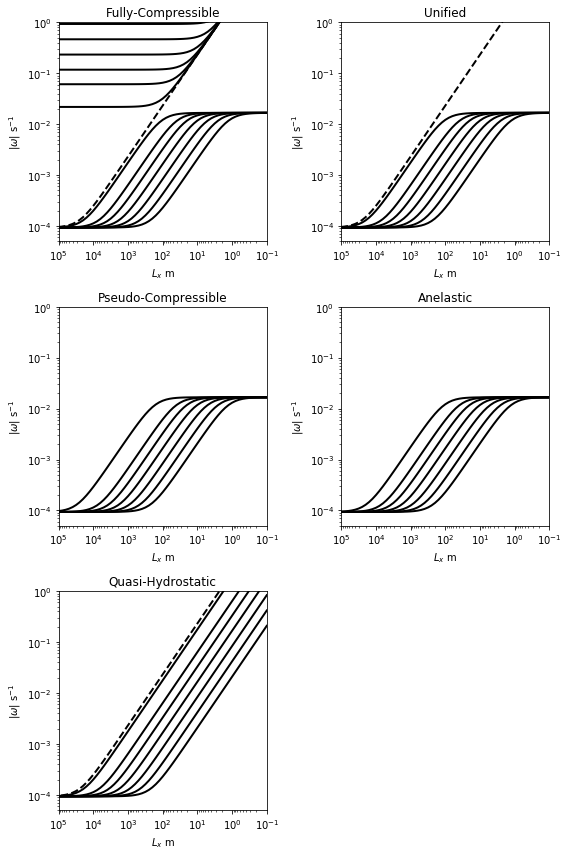

In [4]:
panels = ['(a) ', '(b) ', '(c) ', '(d) ', '(e) ']
jmax = 3
imax = 2
fig, axes = plt.subplots(jmax, imax, figsize=(8, 12))
i = 0
for system in systems:
    d, e, u1, u2 = systems[system]
    plot_dispersion(axes[i // imax, i % imax], system, d, e, u1, u2)
    i += 1

fig.tight_layout()
fig.delaxes(axes[-1, -1])
plt.savefig('dispersion.pdf')

## Plot and save dispersion relationships for barotropic and baroclinic Rossby waves

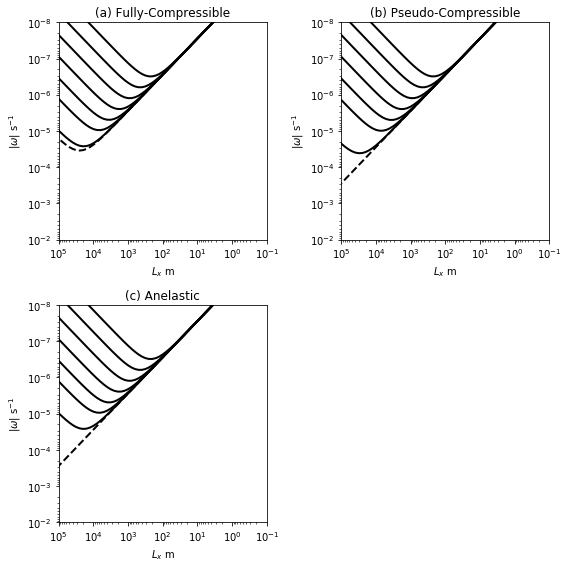

In [5]:
jmax = 2
fig, axes = plt.subplots(jmax, imax, figsize=(8, 8))
i = 0
for system in systems:
    if system == 'Unified' or system == 'Quasi-Hydrostatic':
        continue
    d, e, u1, u2 = systems[system]
    plot_dispersion_qg(axes[i // imax, i % imax], panels[i]+system, u1, u2)
    i += 1

fig.tight_layout()
fig.delaxes(axes[-1, -1])
plt.savefig('dispersion_qg.pdf')